<a href="https://colab.research.google.com/github/yunju-1118/ESAA/blob/main/ESAA_YB_week11_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **회귀 실습 - 자전거 대여 수요 예측**

캐글의 자연거 대여 수요(Bike Sharing Demand) 예측 경연에서 사용된 학습 데이터 세트를 이용해 선형 회귀와 트리 기반 회귀를 비교해보자.

해당 데이터 세트에는 2011년 1월부터 2012년 12월까지 날짜/시간, 기온 ,습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재되어 있다.

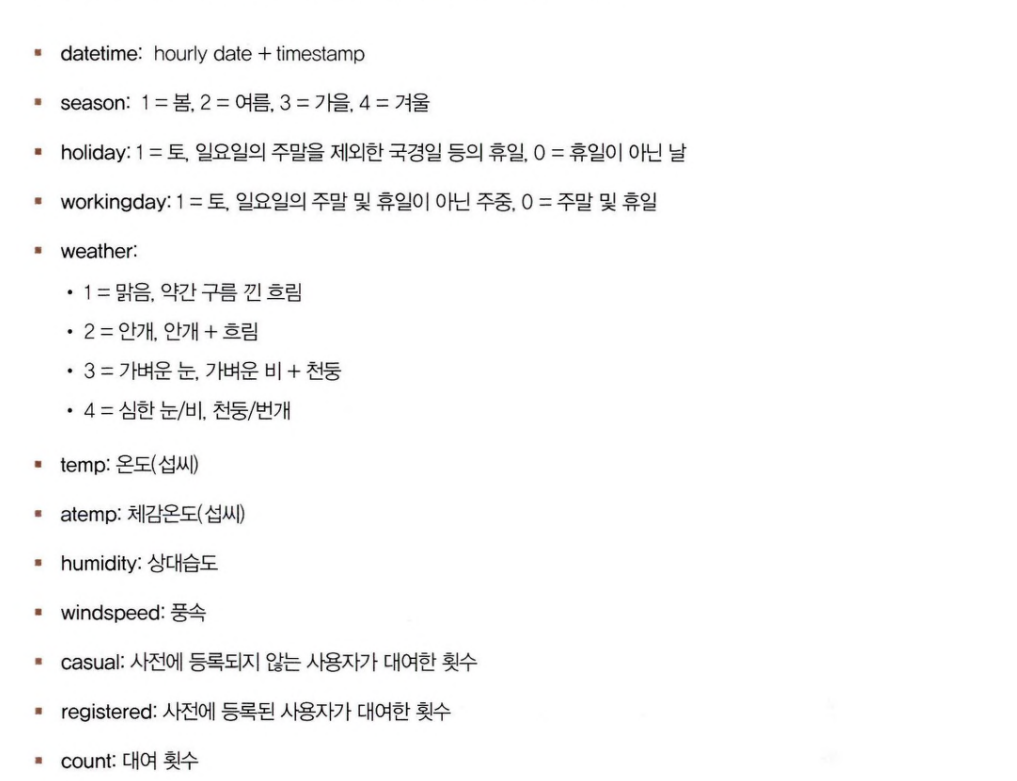

### **데이터 클렌징 및 가공과 데이터 시각화**

데이터 세트를 이용해 모델을 학습한 후 대여 힛수를 예측해보자.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

bike_df = pd.read_csv("bike_train.csv")
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


10886개의 row 데이터 중 Null 데이터는 없으며, 대부분의 칼럼이 int 또는 float 숫자형이며 datetime 칼럼만 object 형이다. Datetime 칼럼의 경우 년-월-일 시:분:초 문자 형식으로 돼 있으므로 이에 대한 가공이 필요하다. datetime을 년, 월, 일, 그리고 시간과 같이 4개의 속성으로 분리해보자. 판다스에서는 datetime과 같은 형태의 문자열을 년도, 월, 일, 시간, 분, 초로 편리하게 변환하려면 먼저 문자열을 'datetime'타입으로 변경해야 한다. 판다스는 문자열을 datetime 타입으로 변환하는 apply(pd.to_datetime) 메서드를 제공한다. 이를 이용해 년, 월, 일, 시간 칼럼을 추출해보자.

In [4]:
# 문자열 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


이제 datetime 칼럼은 삭제해보자.또한 casual 칼럼은 사전에 등록하지 않은 사용자의 자전거 대여 횟수이고 registered는 사전에 등록한 사용자의 대여 횟수이며, casual + registered = count이므로 casual과 registered가 따로 필요하지는 않다. 오히려 상관도가 높아 예측을 저해할 우려가 있으므로 두 칼럼을 삭제한다.

In [5]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

이번에는 주요 컬럼별로 Target 값이 count(대여 횟수)가 어떻게 분포되어 있는지 시각화해보자. 총 8개의 칼럼인 'year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday'에 대해서 칼럼별 값에 따른 count의 합을 표현하기 위해 시본의 barplot을 적용하자. 8개의 칼럼들을 한 번에 시각화 하기 위해 matplotlib의 subplots( )을 기반으로 barplot을 표현해보자.

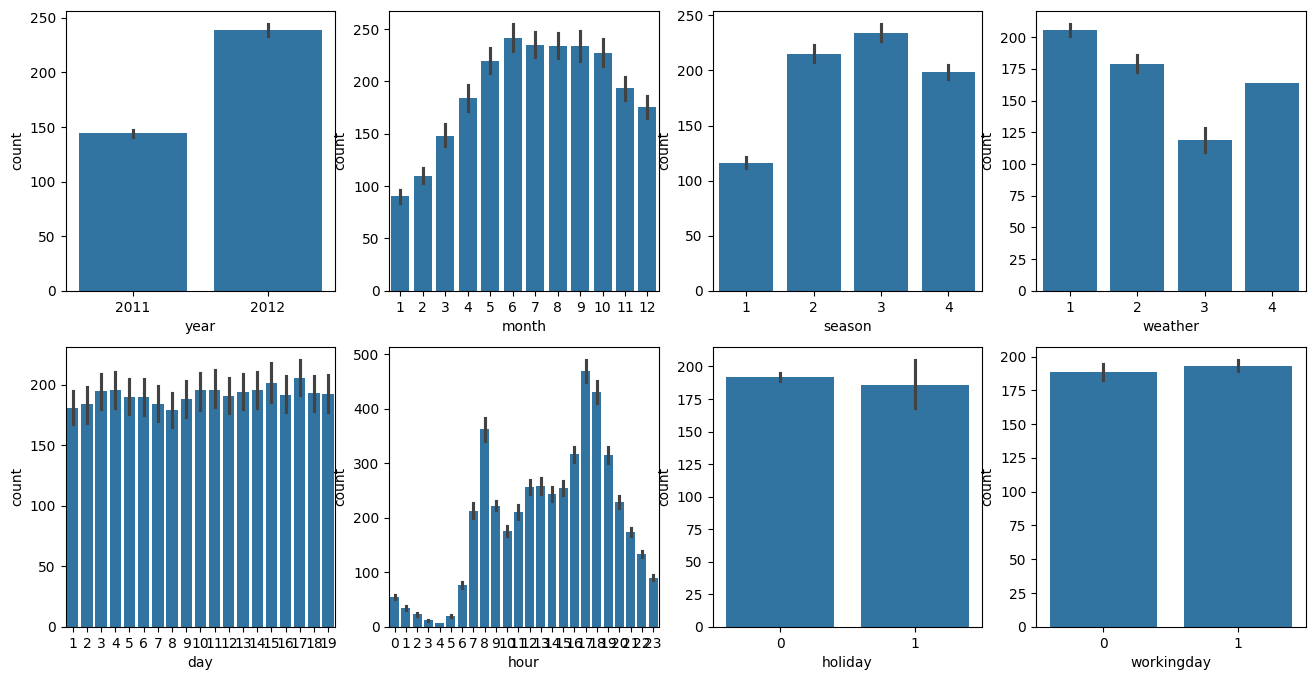

In [6]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
cat_features = ['year','month','season','weather','day','hour','holiday','workingday']
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
  row = int(i/4)
  col = i%4
  # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
  sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

year별 count를 보면 2012년이 2011년보다 상대적으로 높다. 이는 시간이 지날수록 자전거 대여 횟수가 지속적으로 증가한 결과라고 여겨진다. month의 경우 1,2,3이 낮고, 6,7,8,9월이 높다. 또한, season을 보면 봄과 겨울이 낮고 여름, 가을이 높다. weather의 경우 눈또는 비가 있는 경우가 낮고 맑거나 약간 안개가 있는 경우 높다.

hour의 경우 오전 출근 시간(8)과 오후 퇴근 시간(17,18)이 상대적으로 높다. day간의 차이는 크지 않으며 holiday 또는 workingday는 주중일 경우가 상대적으로 약간 높다.

다양한 회귀 모델을 데이터 세트에 적용해 예측 성능을 측정해보자.

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y,pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# 사이킷런의 mean_squared_error( )를 이용해 RMSE 계산
def rmse(y,pred):
  return np.sqrt(mean_squared_error(y,pred))

# MAE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y,pred):
  rmsle_val = rmsle(y,pred)
  rmse_val = rmse(y,pred)
  # MAE는 사이킷런의 mean_absolute_error()로 계산
  mae_val = mean_absolute_error(y,pred)
  print('MAE: {0:.3f}, RMSE: {1:.3f}, RMSLE: {2:.3f}'.format(mae_val, rmse_val, rmsle_val))

위 rmsle 함수를 만들 때 한 가지 주의해야 할 점은 데이터 값의 크기에 따라 overflow/underflow 오류가 발생하기 쉽다는 것이다.

In [8]:
# 다음과 같은 rmsle 구현은 오버플로나 언더플로 오류를 발생하기 쉽다.
def rmsle(y,pred):
  msle = mean_squared_log_error(y,pred)
  rmsle = np.sqrt(mse)
  return rmsle

따라서 log보다는 log1p를 이용하는데 이는 log(1+x)로 변환되므로 x값이 0이 되더라도 log(0)인 무한대가 되지 않고 log(1)인 0이 되어 오버플로/언더플로 문제를 해결한다. 그리고 log1p()로 변환된 값은 다시 넘파이의 expm1( ) 함수로 쉽게 원래의 스케일로 복원될 수 있다.

### **로그 변환, 피처 인코딩과 모델 학습/예측/평가**
회귀 모델을 이용해 자전거 대여 횟수를 예측해보자. 회귀 모델을 적용하기 전에 데이터 세트에 대해 결괏값이 정규 분포로 되어 있는지 확인하고 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처를 인코딩해야 한다.

먼저 사이킷런의 LinearRegression 객체를 이용해 회귀 예측을 해보자.

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,
                                                    random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

MAE: 105.924, RMSE: 140.900, RMSLE: 1.165


예측 오류가 비교적 큰 값으로 나타난다. 실제 값과 예측값이 어느 정도 차이가 나는지 DataFrame의 칼럼으로 만들어 오류 값이 가장 큰 순으로 5개만 확인해보자.

In [14]:
def get_top_error_data(y_test, pred, n_tops=5):
  # DataFrame의 칼럼으로 실제 대여 횟수와 예측값을 서로 비교할 수 있도록 생성
  result_df = pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted_count'] = np.round(pred)
  result_df['diff'] = np.abs(result_df['predicted_count'] - result_df['real_count'])

  # 예측값과 실제 값이 가장 큰 데이터 순으로 출력
  print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
966          884            327.0  557.0
3151         798            241.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


예측 오류가 꽤 크게 나타난다. 회귀에서 이렇게 큰 예측 오류가 발생할 경우 가장 먼저 살펴볼 것은 Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인하는 것이다. Target 값의 분포는 정규 분포 형태가 가장 좋다. 그렇지 않고 왜곡된 경우에는 회귀 예측 성능이 저하되는 경우가 발생하기 쉽다. 판다스 DataFrame의 hist( )를 이용해 자전거 대여 모델의 Target 값인 count 칼럼이 정규분포를 이루는지 확인해본다.

<Axes: >

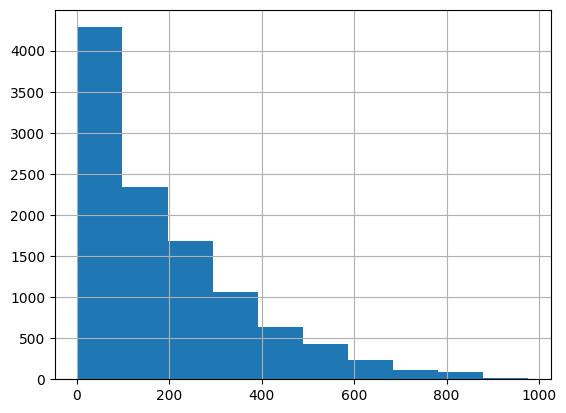

In [15]:
y_target.hist()

count 칼럼 값이 정규분포가 아닌 0-200사이에 왜곡되어 있는 것을 알 수 있다. 이렇게 왜곡된 값을 정규 분포 형태로 바꾸는 가장 일반적인 방법은 로그를 적용해 변환하는 것이다. 이렇게 변경된 Target 값을 기반으로 학습하고 예측한 값은 다시 expm1( ) 함수를 적용해 원래 scale 값으로 원상 복구하면 된다.

<Axes: >

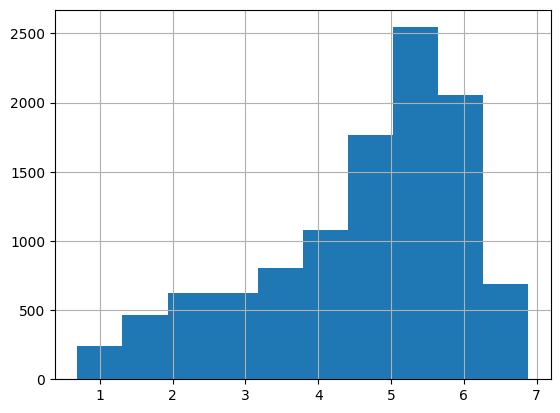

In [16]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [18]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log,
                                                    test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환되었으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습되어 예측했으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

MAE: 109.286, RMSE: 162.594, RMSLE: 1.017


RMSLE 오류는 줄어들었지만 RMSE는 오히려 늘어났다. 이번에는 개별 피처들의 인코딩을 적용해보자. 먼저 각 피처의 회귀 계숫값을 시각화해보자.

<Axes: ylabel='None'>

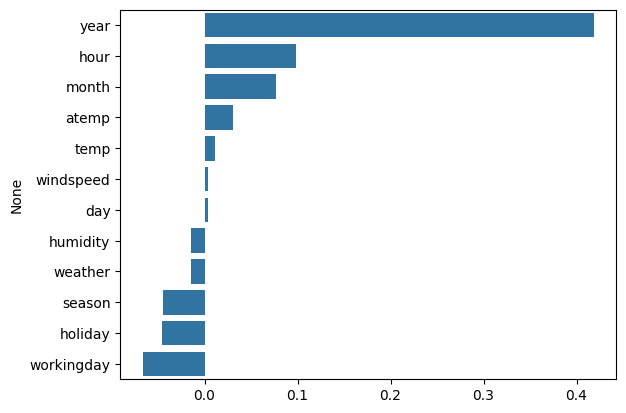

In [19]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

year, hour, month, season, holiday, workingday 피처들의 회귀 계수 영향도가 상대적으로 높다. 이들의 경우 개별 숫자값의 크기가 의미있는 것이 아니기에 모두 카테고리형 피처라고 볼 수 있다.

사이킷런은 카테고리만을 위한 데이터 타입이 없으며 모두 숫자로 변환해야 한다. 하지만 이처럼 숫자형 카테고리 값을 선형 회귀에 사용할 경우 회귀 계수를 연산할 때 이 숫자값에 크게 영향을 받는 경우가 발생할 수 있다. 따라서, 선형 회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야 한다.

In [20]:
# 'year','month','day','hour' 등의 피처들을 one-hot encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour',
                                                     'holiday','workingday','season','weather'])


In [21]:
# 원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  if is_expm1:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###', model.__class__.__name__,'###')
  evaluate_regr(y_test,pred)
# end of function get_model_predict


# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
MAE: 63.382, RMSE: 97.688, RMSLE: 0.590
### Ridge ###
MAE: 63.893, RMSE: 98.529, RMSLE: 0.590
### Lasso ###
MAE: 72.803, RMSE: 113.219, RMSLE: 0.635


원-핫 인코딩을 적용하고 나서 선형 회귀의 예측 성능이 많이 향상되었다. 원-핫 인코딩된 데이터 세트에서 회귀 계수가 높은 피처를 다시 시각화해보자.

<Axes: ylabel='None'>

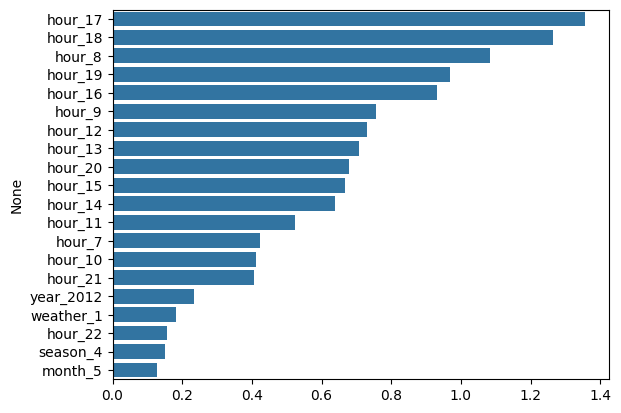

In [22]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

원-핫 인코딩을 통해 피처들의 영향도가 달라졌고, 모델의 성능도 향상되었다. 반드시 그런 것은 아니지만 선형 회귀의 경우 중요 카테고리성 피처들을 원-핫 인코딩으로 변환하는 것은 성능에 중요한 영향을 미칠 수 있다.

이번에는 회귀 트리를 이용해 회귀 예측을 수행해보자. 원-핫 인코딩된 피처 데이터 세트를 그대로 이용해 랜덤 포레스트, GBM, XGBoost, LightGBM을 순차적으로 성능 평가해보자.

In [23]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
  get_model_predict(model, X_train.values, X_test.values,
                    y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
MAE: 31.147, RMSE: 50.275, RMSLE: 0.354
### GradientBoostingRegressor ###
MAE: 32.746, RMSE: 53.332, RMSLE: 0.330
### XGBRegressor ###
MAE: 31.357, RMSE: 51.475, RMSLE: 0.339
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
MAE: 29.029, RMSE: 47.215, RMSLE: 0.319


앞의 선형 회귀 모델보다 회귀 예측 성능이 개선되었다. 하지만 이것이 회귀 트리가 선형 회귀보다 더 나은 성능을 갖는다는 의미는 아니다.

## **회귀 실습 - 캐글 주택 가격: 고급 회귀 기법**


In [31]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('house_train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [25]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\n Null 칼럼과 그 건수:\n', isnull_series[isnull_series>0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

 Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


데이터 세트는 1460개의 레코드와 81개의 피처로 구성돼 있으며 피처의 타입은 숫자형은 물론 문자형도 많다. Target을 제외한 80개의 피처 중 43개가 문자형이며 나머지가 숫자형이다. 데이터 양에 비해 Null값이 너무 많은 피처도 있다. 해당 피처는 드롭한다.

회귀 모델을 적용하기 전에 타깃 값의 분포도가 정규 분포인지 확인해보자.

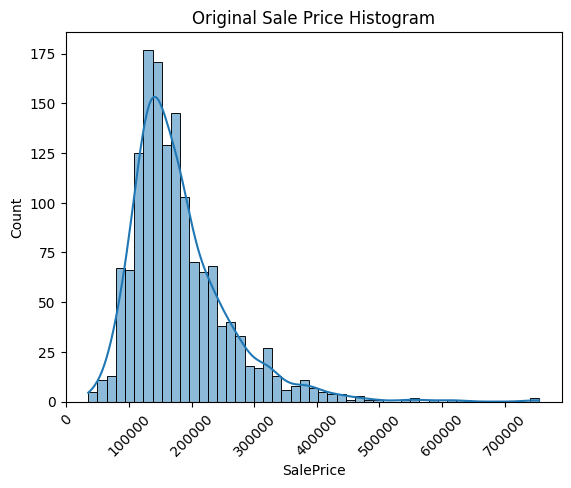

In [27]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

정규 분포 형태로 변화하기 위해 로그 변환을 적용한다.

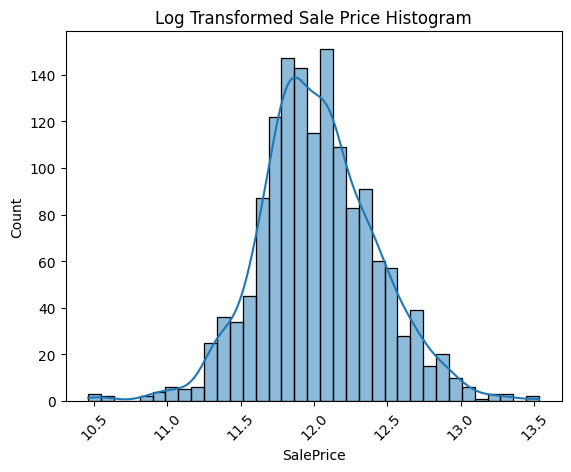

In [32]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
plt.xticks(rotation=45)
sns.histplot(log_SalePrice, kde=True)
plt.show()

SalePrice를 로그 변환한 뒤 DataFrame에 반영한다.

Null 값이 많은 피처인 PoolQC, MiscFeature, Alley, Fence, FireplaceQu는 삭제한다. 또한 ID도 단순 식별자이므로 삭제한다. LotFrontage는 Null이 259개로 비교적 많으나 평균값으로 대체한다. 나머지 Null 값이 많지 않으므로 숫자형의 경우 평균값으로 대체한다.

In [33]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley','Fence','FireplaceQu'],axis=1, inplace=True)

#드롭하지 않는 숫자형 Null 칼럼은 평균값으로 대체
# 숫자형 열만 골라서 평균을 계산
house_df.fillna(house_df.select_dtypes(include='number').mean(), inplace=True)


# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 Type: \n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


문자형 피처를 제외하고 Null 값이 존재하지 않는다. 문자형 피처는 모두 원-핫 인코딩으로 변환한다. pd.get_dummies는 문자열 피처를 변환하면서 Null 값은 모든 인코딩 값이 0으로 변환되는 방식으로 대체해주므로 별도의 Null 값을 대체하는 로직이 필요없다.

In [34]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shae:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 Type:\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shae: (1460, 270)
## Null 피처의 Type:
 Series([], dtype: object)


원-핫 인코딩 후 피처가 75개에서 271개로 증가했다. 그리고 Null 값을 가진 피처는 이제 존재하지 않는다.

### **선형 회귀 모델 학습/예측/평가**

타깃 값이 SalePrice가 로그 변환되었기에 예측 결과 오류에 RMSE만 적용하면 RMSLE가 자동으로 측정된다.

In [35]:
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse=np.sqrt(mse)
  print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse,3))
  return rmse

def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

In [36]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                    test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.127
Lasso 로그 변환된 RMSE: 0.176


[np.float64(0.13183184688250857),
 np.float64(0.1274058283626616),
 np.float64(0.17628250556471403)]

라쏘 회귀의 경우 회귀 성능이 타 회귀 방식보다 많이 떨어져 하이퍼 파라미터 튜닝이 필요해 보인다.

피처별 회귀 계수를 시각화해 모델별로 어떠한 피처의 회귀 계수로 구성되는지 확인해보자. 피처가 많기에 회귀 계수 값 상위 10개, 하위 10개의 피처명과 그 회귀 계수 값을 갖는 판다스 Series 객체를 반환하는 함수를 만들자.

In [37]:
def get_top_bottom_coef(model, n=10):
  # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명
  coef = pd.Series(model.coef_, index=X_features.columns)

  # 상위 10개, 하위 10개의 회귀 계수를 추출해 반환
  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

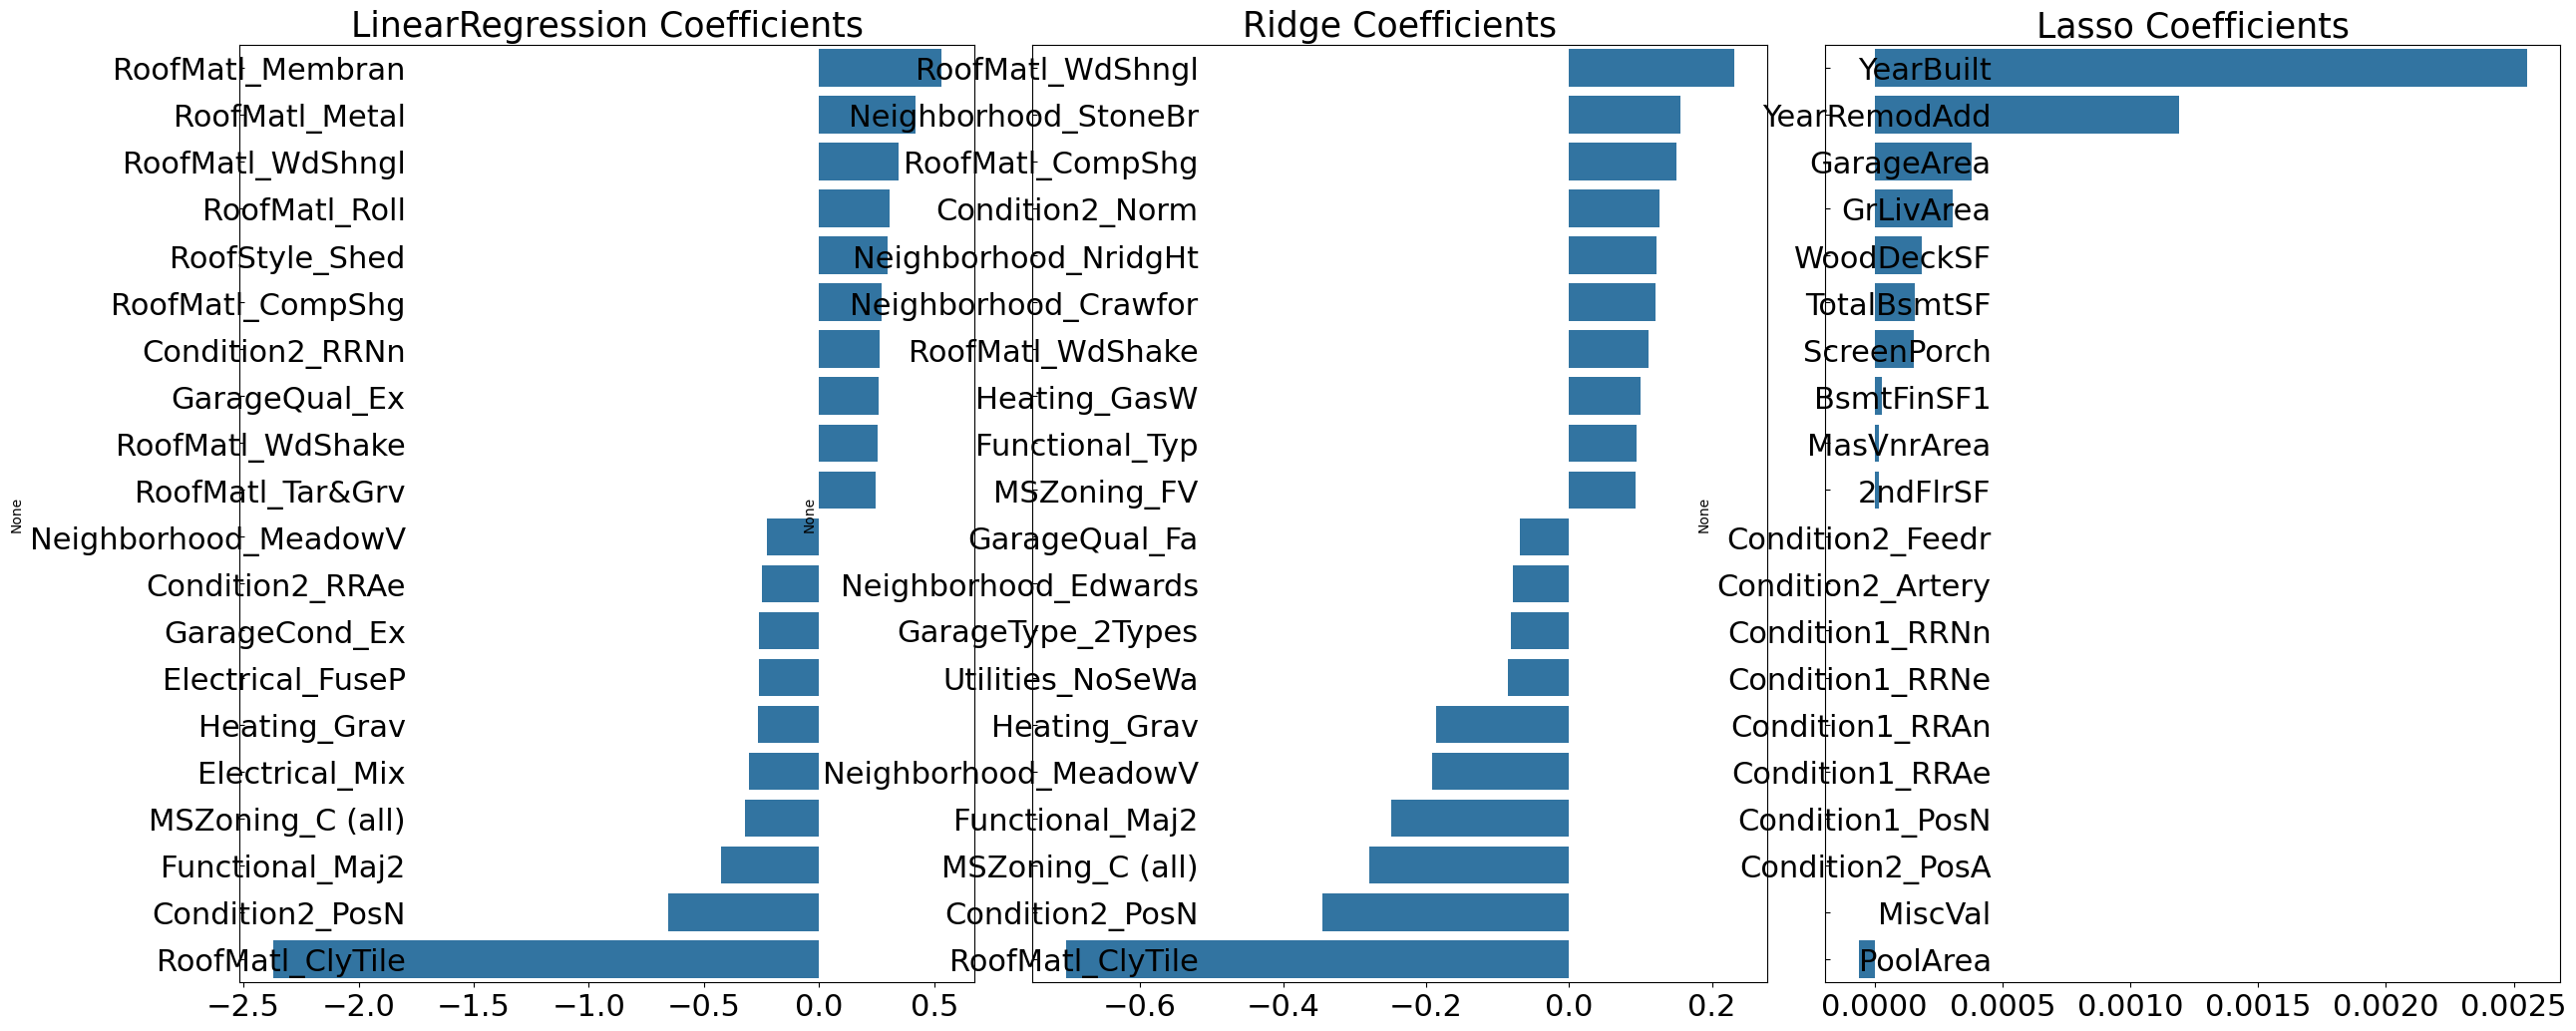

In [38]:
def visualize_coefficient(models):
  # 3개 회귀 모델의 시각화를 위해 3개 칼럼을 가지는 subplot 생성
  fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
  fig.tight_layout()

  # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
  for i_num, model in enumerate(models):
    # 상위 10개, 하위 10개 회귀 계수를 구하고 이를 concat으로 결합
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])

    # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
    axs[i_num].set_title(model.__class__.__name__+' Coefficients', size=25)
    axs[i_num].tick_params(axis="y", direction="in", pad=-120)
    for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

모델별 회귀 계수를 보면 OLS 기반의 LinearRegression과 Ridge의 경우는 회귀 계수가 유사한 형태로 분포되어 있다. 하지만, Lasso는 전체적으로 회귀 계수 값이 매우 작고, 그 중에 YearBuilt가 가장 크고 다른 피처의 회귀 계수가 매우 작다. 혹시 학습 데이터의 데이터 분할에 문제가 생긴건지 전체 데이터 세트인 X_features와 y_target을 5개의 교차 검증 폴드 세트로 분할해 평균 RMSE를 측정해보자.

In [41]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

  for model in models:
    rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                         scoring="neg_mean_squared_error", cv=5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} CV 평균 RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
    print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg,3)))

# 앞 예제에서 학습한 ridge, lasso 모델의 CV RMSE 값 출력
models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


Ridge CV 평균 RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV 평균 RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


5개의 폴드 세트로 학습해도 라쏘의 경우 릿지 모델보다 성능이 떨어진다. 릿지와 라쏘 모델에 대해 alpha 하이퍼 파라미터를 변화시키며 최적 값을 도출해보자.

In [45]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid = params,
                            scoring='neg_mean_squared_error', cv=5)
  grid_model.fit(X_features, y_target)
  rmse = np.sqrt(-1*grid_model.best_score_)
  print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                                           np.round(rmse,4), grid_model.best_params_))
ridge_params = {'alpha': [0.05, 0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha': [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


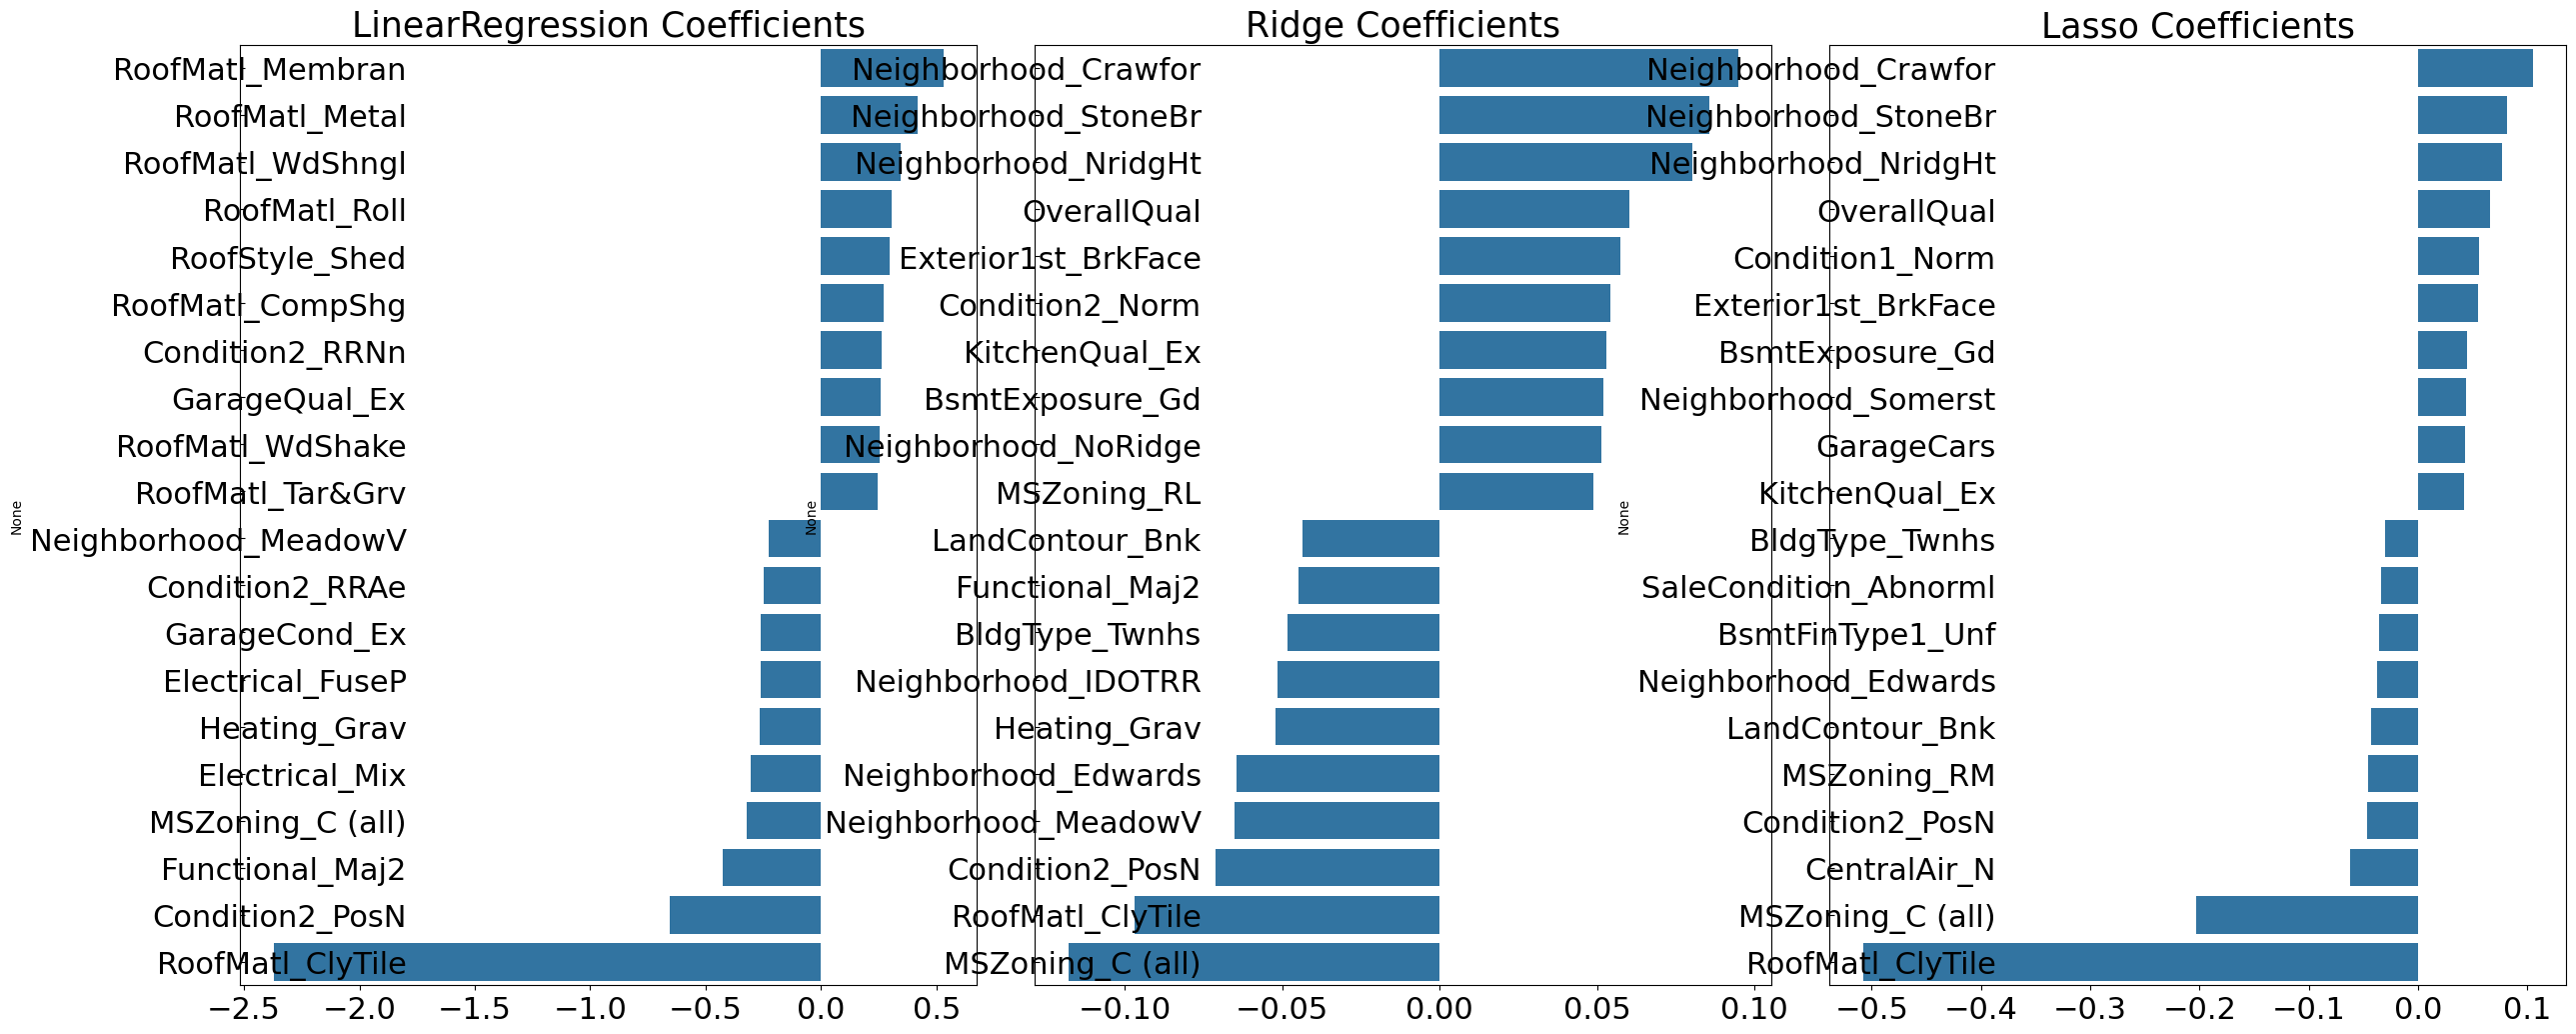

In [46]:
#앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 RMSE 출력
models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

#모든 모델의 회귀 계수 시각화
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [48]:
from scipy.stats import skew

#object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index=house_df.dtypes[house_df.dtypes!='object'].index
#house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환, apply lambda로 skew() 호출
skew_features=house_df[features_index].apply(lambda x: skew(x))
#skew(왜곡) 정도가 1 이상인 칼럼만 추출
skew_features_top=skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [50]:
house_df[skew_features_top.index]=np.log1p(house_df[skew_features_top.index])

In [51]:
#왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터 세트 생성
house_df_ohe=pd.get_dummies(house_df)
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.2,
                                               random_state=156)

#피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params={'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1376, 최적 alpha:{'alpha': 1}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1386, 최적 alpha:{'alpha': 0.001}


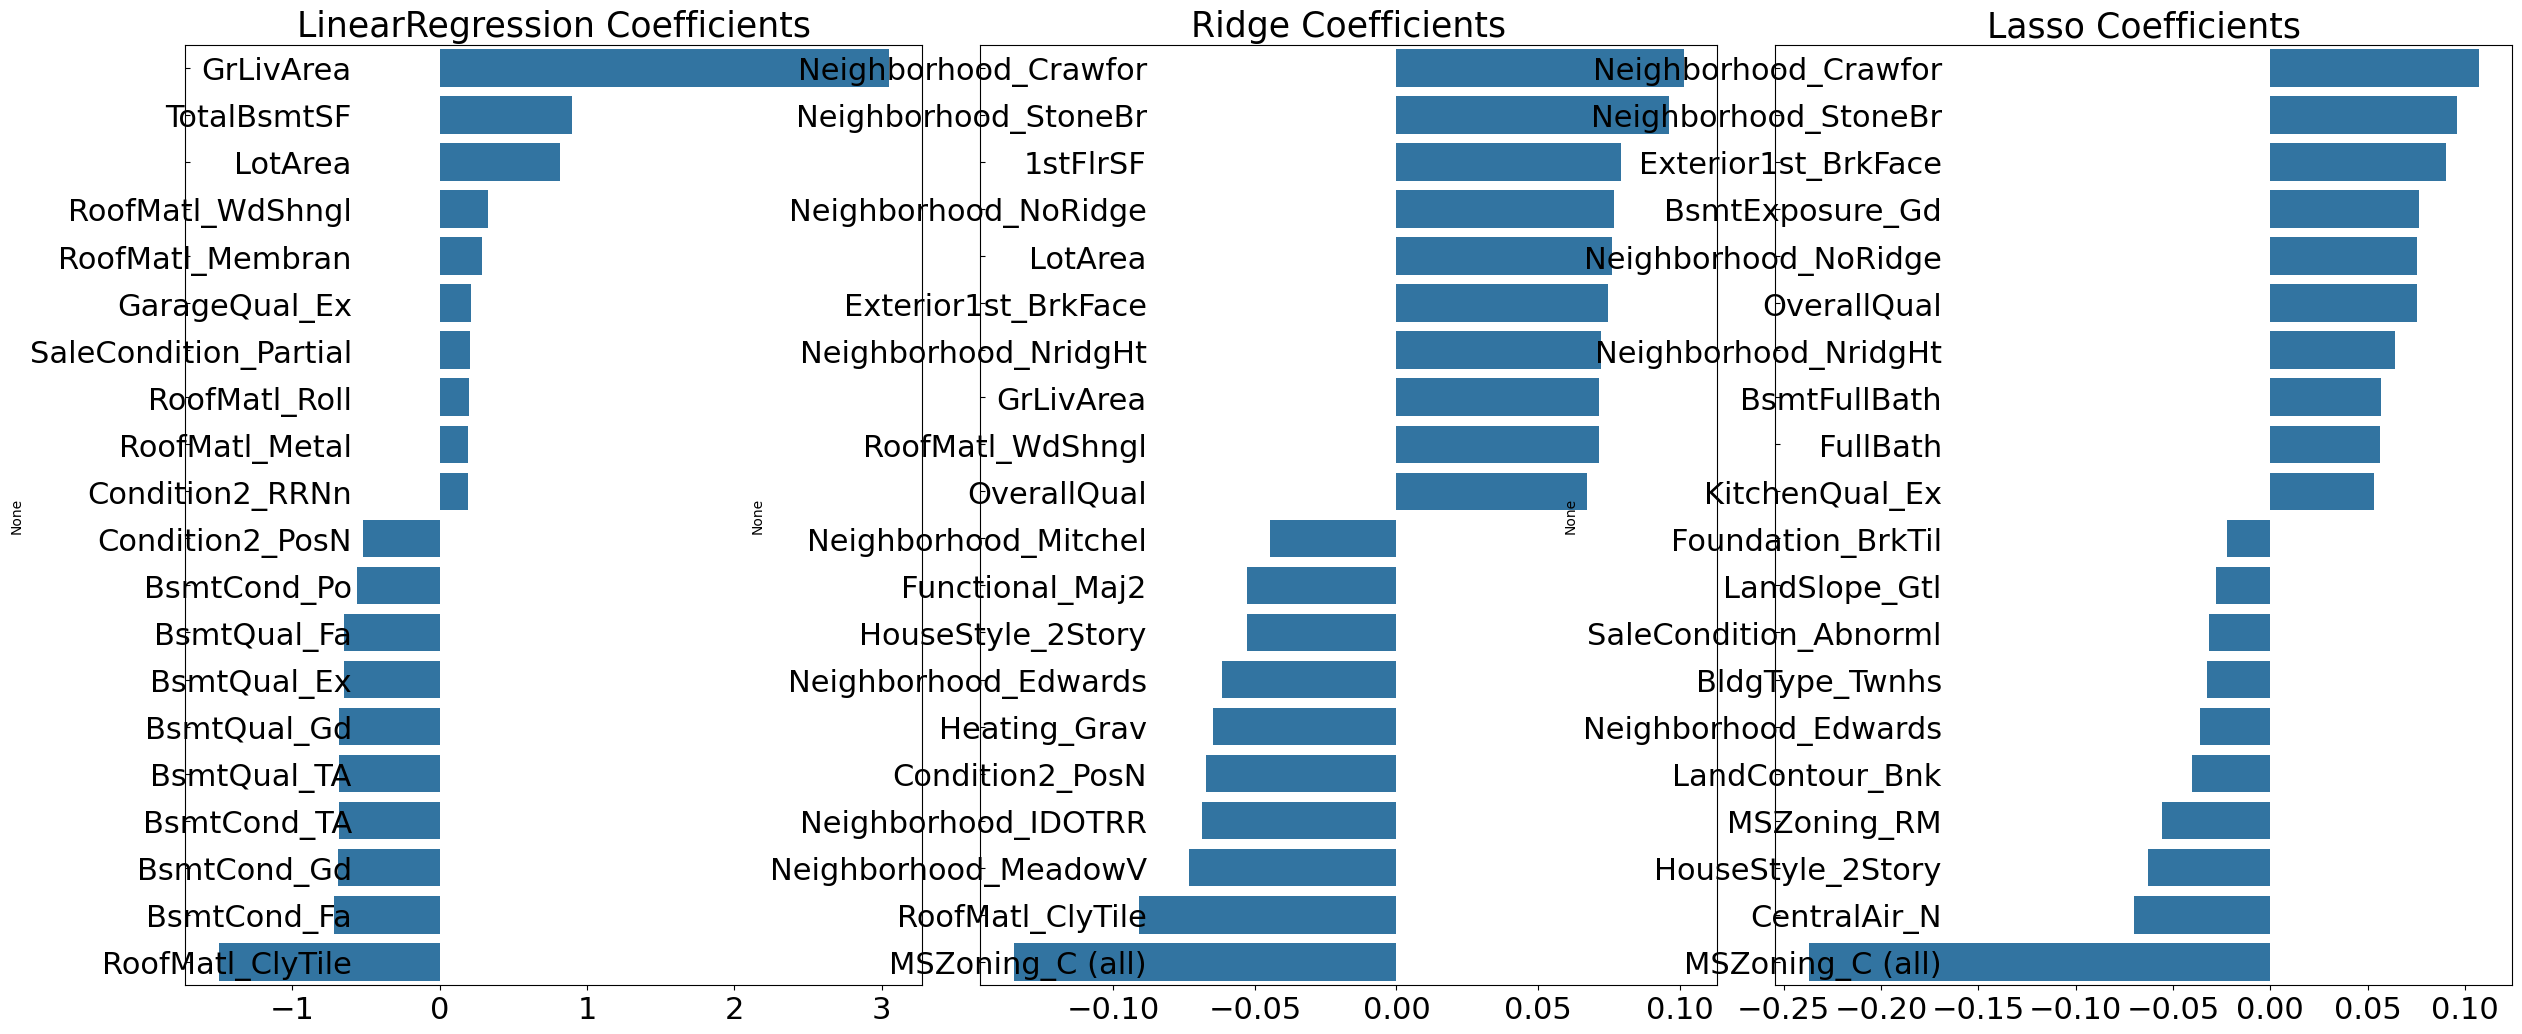

In [52]:
#앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 회귀 계수 시각화
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

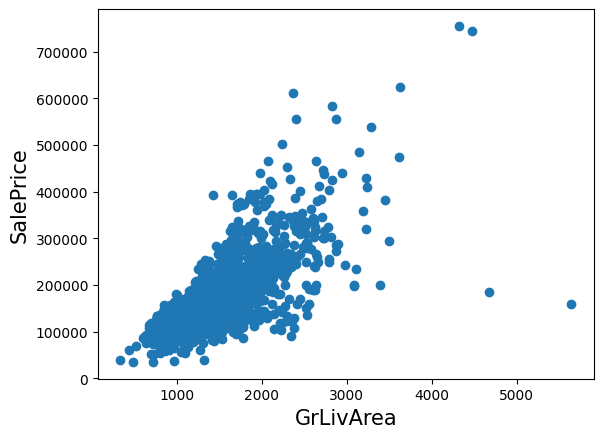

In [53]:
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [54]:
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.2,
                                                  random_state=156)

ridge_params={'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1376, 최적 alpha:{'alpha': 1}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1386, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.135
Lasso 로그 변환된 RMSE: 0.132


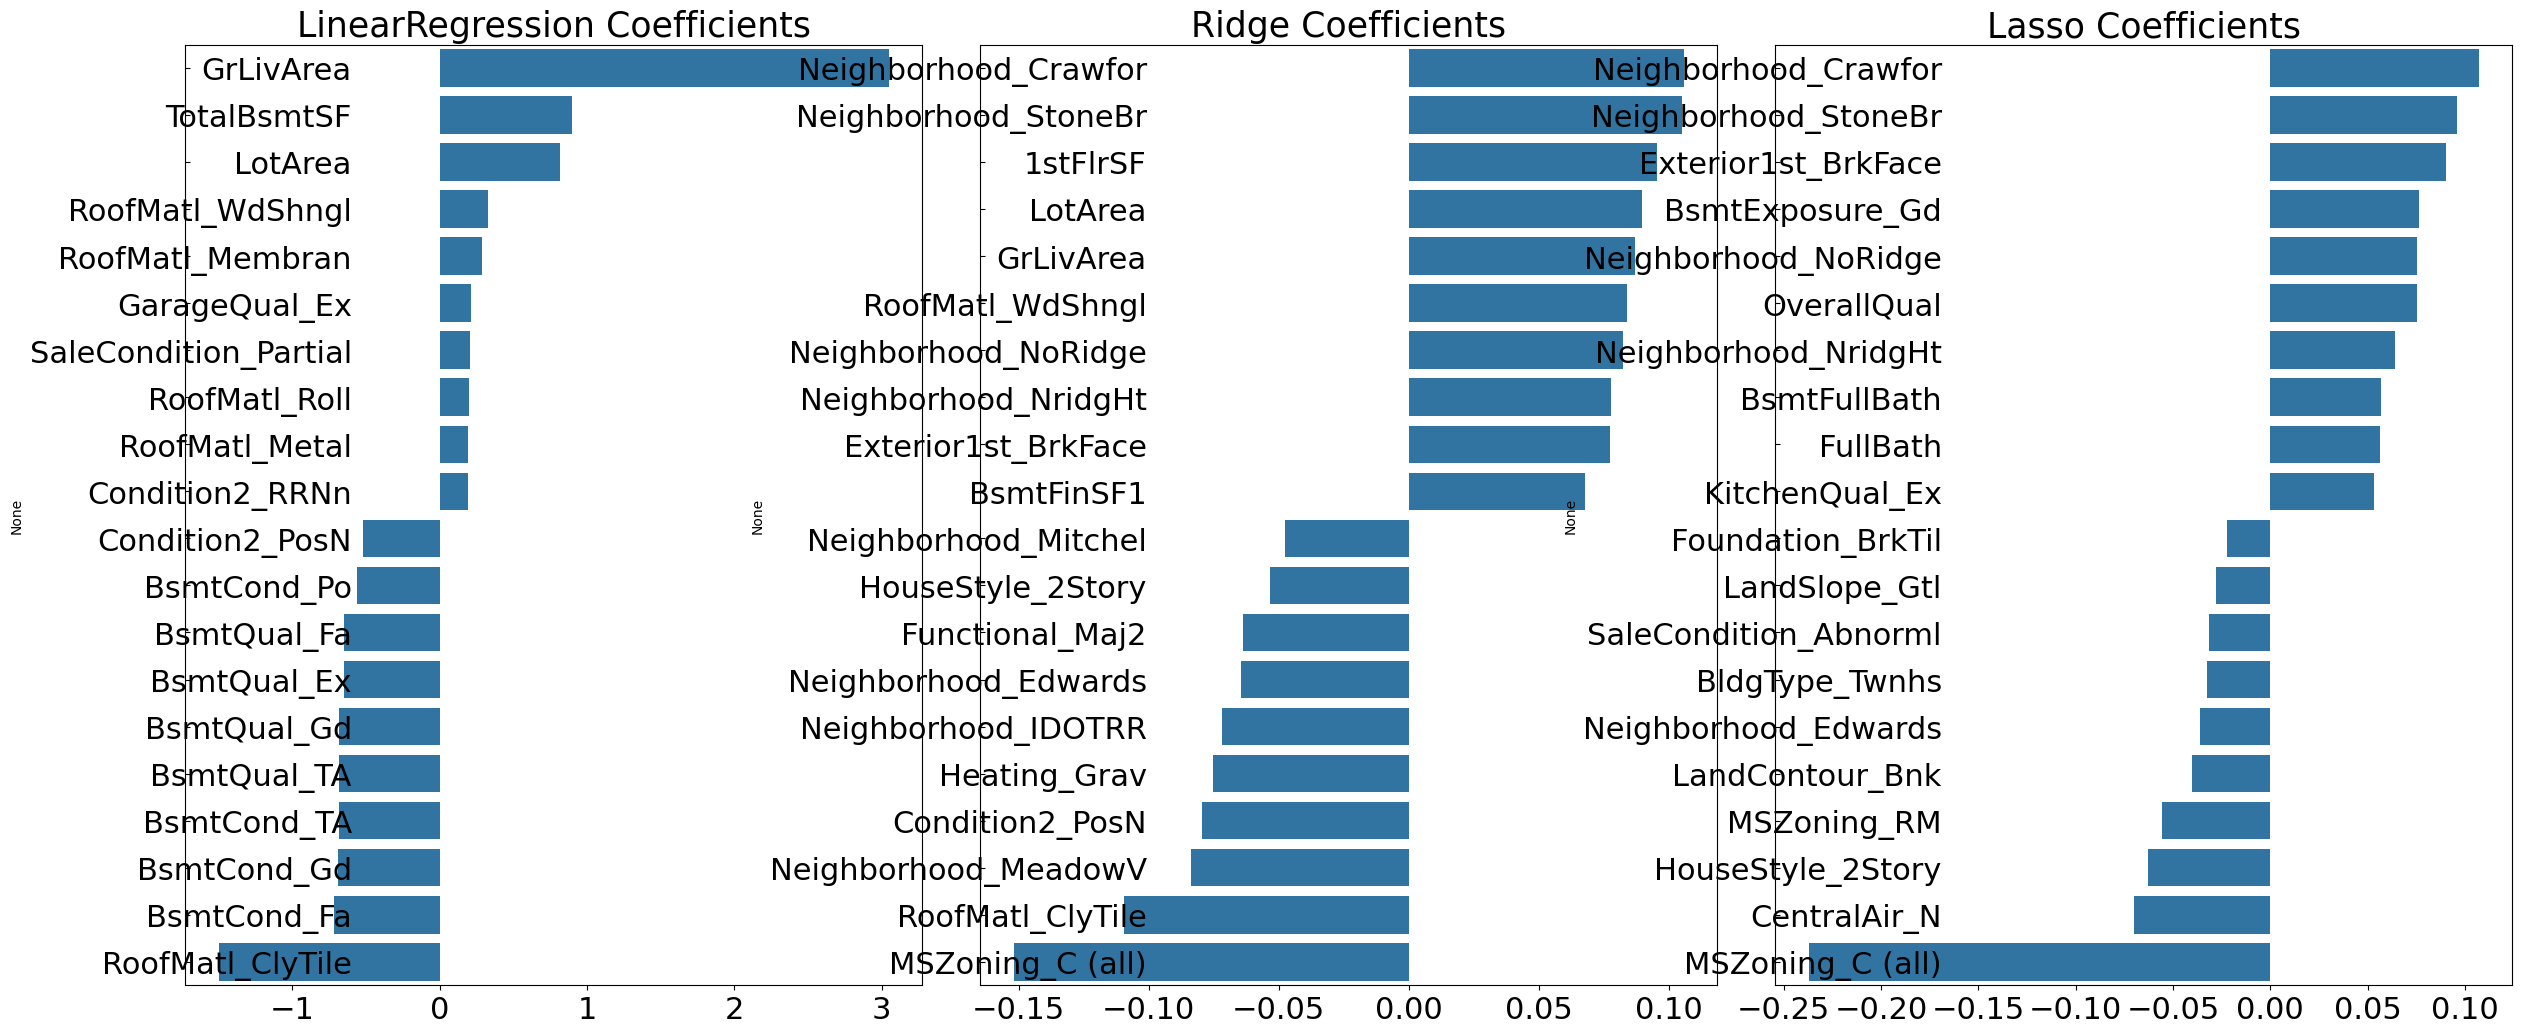

In [55]:
#앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 RMSE 출력
models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

#모든 모델의 회귀 계수 시각화
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### **회귀 트리 모델 학습/예측/평가**


In [56]:
from xgboost import XGBRegressor

xgb_params={'n_estimators':[1000]}
xgb_reg=XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.1265, 최적 alpha:{'n_estimators': 1000}


In [57]:
from lightgbm import LGBMRegressor

lgbm_params={'n_estimators':[1000]}
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                       subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.417529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3159
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 172
[LightGBM] [Info] Start training from score 12.021409
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3172
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 169
[LightGBM] [Info] Start training from score 12.023288
[LightGBM] [Warning] Found

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3158
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 169
[LightGBM] [Info] Start training from score 12.023289


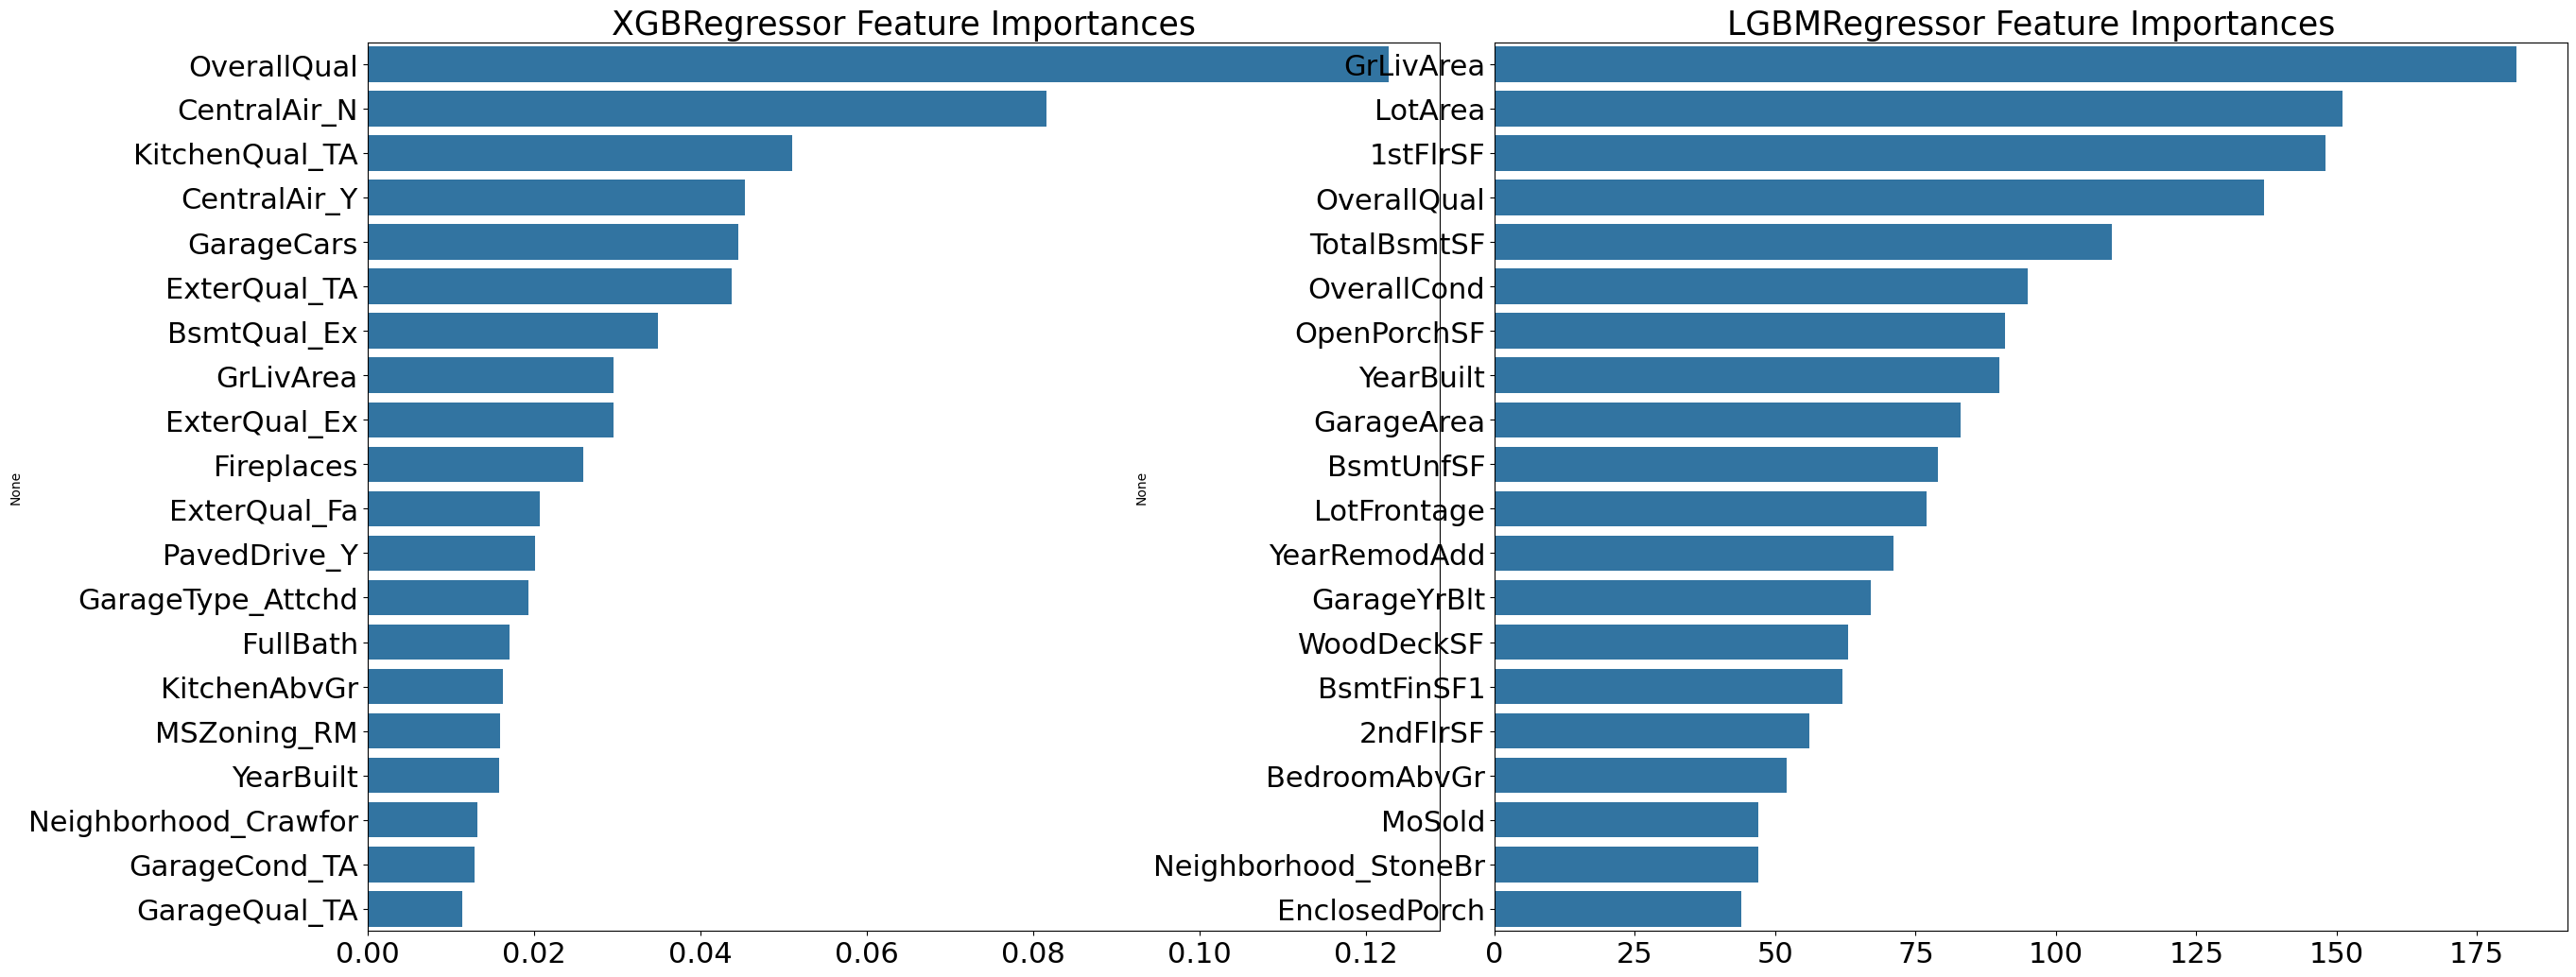

In [58]:
def get_top_features(model):
    ftr_importances_values=model.feature_importances_
    ftr_importances=pd.Series(ftr_importances_values, index=X_features.columns)
    ftr_top20=ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_importances(models):
    fig, axs=plt.subplots(figsize=(24,10), nrows=1, ncols=2)
    fig.tight_layout()
    for i_num, model in enumerate(models):
        model.fit(X_train, y_train)
        ftr_top20=get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index, ax=axs[i_num])

models=[xgb_reg, lgbm_reg]
visualize_importances(models)

### **회귀 모델의 예측 결과 혼합을 통한 최종 예측**


In [59]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value=preds[key]
        mse=mean_squared_error(y_test, pred_value)
        rmse=np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

#개별 모델의 학습
ridge_reg=Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
#개별 모델 예측
ridge_pred=ridge_reg.predict(X_test)
lasso_pred=lasso_reg.predict(X_test)

#개별 모델 예측값 혼합으로 최종 예측값 도출
pred=0.4*ridge_pred+0.6*lasso_pred
preds={'최종 혼합': pred,
       'Ridge':ridge_pred,
       'Lasso':lasso_pred}

#최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.13203492868790875
Ridge 모델의 RMSE: 0.13532638223453977
Lasso 모델의 RMSE: 0.1322972273523919


In [60]:
xgb_reg=XGBRegressor(n_estimators=1000, learning_rate=0.05,
                     colsample_bytree=0.5, subsample=0.8)
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                       subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred=xgb_reg.predict(X_test)
lgbm_pred=lgbm_reg.predict(X_test)

pred=0.5*xgb_pred+0.5*lgbm_pred
preds={'최종 혼합':pred,
       'XGBM':xgb_pred,
       'LGBM':lgbm_pred}

get_rmse_pred(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3158
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 169
[LightGBM] [Info] Start training from score 12.023289
최종 혼합 모델의 RMSE: 0.1226812996722181
XGBM 모델의 RMSE: 0.1279065037633749
LGBM 모델의 RMSE: 0.12332762730885556


### **스태킹 앙상블 모델을 통한 회귀 예측**


In [61]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 테이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    #지정된 n_folds 값으로 KFold 생성
    kf=KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred=np.zeros((X_train_n.shape[0], 1))
    test_pred=np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트:', folder_counter, '시작')
        X_tr=X_train_n[train_index]
        y_tr=y_train_n[train_index]
        X_te=X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index,:]=model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter]=model.predict(X_test_n)

    #폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean=np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [62]:
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환
X_train_n=X_train.values
X_test_n=X_test.values
y_train_n=y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환.
ridge_train, ridge_test=get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test=get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test=get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test=get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
Lasso model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
XGBRegressor model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
LGBMRegressor model 시작
	 폴드 세트: 0 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2960
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 158
[LightGBM] [Info] Start training from score 12.024507
	 폴드 세트: 1 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Num

In [63]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train=np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test=np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso=Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final=meta_model_lasso.predict(Stack_final_X_test)
mse=mean_squared_error(y_test, final)
rmse=np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.11897020564379274
